# Filter Design

In [23]:
%pylab
%matplotlib inline
from scipy import signal

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


## Ideal Filters

![image](ideal_filters.png)

Ideal filters cannot be realized:

- for analog filters the laws of physics prevents this,
- for discrete filters we are stuck with the 'uncertainty principle' (finite support in frequency domain corresponds with infinite support in time domain, and vv).

## Analog Low-Pass Filters

Analog filters very often serve as the starting point in designing a digital filter.

Consider the following simple low-pass filter

![image](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/RC_Divider.svg/200px-RC_Divider.svg.png)

Its transfer function is

$$ H(s)=\frac{1/Cs}{1/Cs+R} = \frac{1}{sRC+1} $$

In [56]:
H = signal.lti([1], [1,1])

In [57]:
w = logspace(-3,5)
w, Hw = H.freqresp(w)

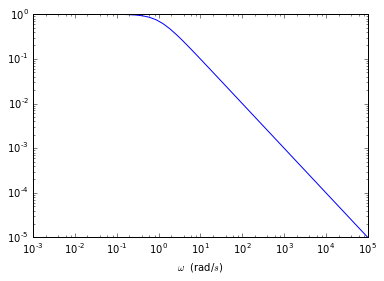

In [58]:
loglog(w,abs(Hw));
xlabel(r'$\omega$  (rad/$s$)');

In [22]:
signal.lp2hp([1],[1,2,1])

(array([ 1.,  0.,  0.]), array([ 1.,  2.,  1.]))

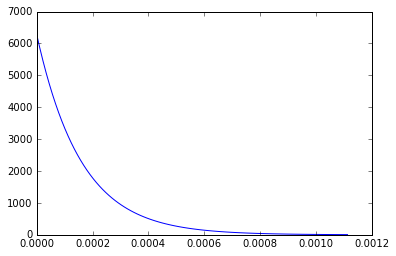

In [13]:
ws, ir = H.impulse()
plot(ws, ir);

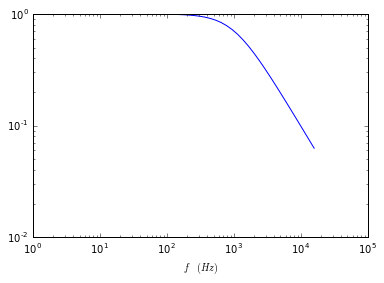

In [12]:
loglog(w/(2*pi),abs(Hw));
xlabel(r'$f\quad (Hz)$');

A second order low-pass filter (in standard form where $\omega_c=1$) has transfer function:

$$  H(s) = \frac{1}{s^2 + \frac{s}{Q} + 1)} $$

where $Q$ is the *quality factor*.

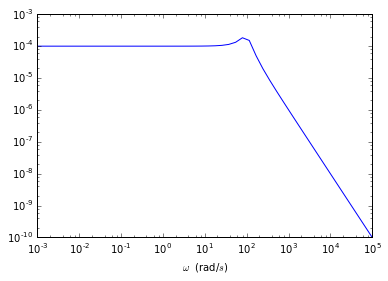

In [55]:
Q = 2
H2 = signal.lti([1],[1,100/Q,10000])
w2, H2w = H2.freqresp(w=logspace(-3,5))
loglog(w2, abs(H2w));
xlabel(r'$\omega$  (rad/$s$)');

To put the central frequency at say 1000 Hz we have to rescale the frequencies (remember that we substitute $s=j\omega$ when we are looking at the frequency response), i.e. replace $s$ with $s/\omega_c$:

$$ H(s) = \frac{\omega_c^2}{s^2+s \frac{\omega_c}{Q} + \omega_c^2} $$

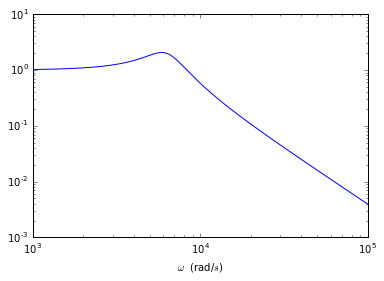

In [15]:
Q = 2
wc = 2*pi*1000;
H2 = signal.lti([wc**2],[1,wc/Q,wc**2])
w2, H2w = H2.freqresp()
loglog(w2, abs(H2w));
xlabel(r'$\omega$  (rad/$s$)');

Below we plot the frequency reponse of both a first order and a second order low pass filter. The plot clearly shows that the second order filter has a steeper curve in the reject region of the filter. I.e. the second order filter better approximates the ideal filter.

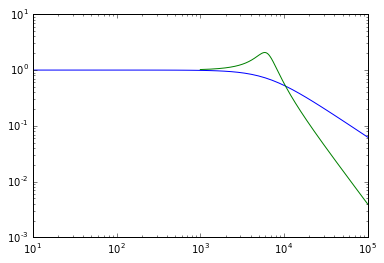

In [16]:
loglog(w,abs(Hw));
loglog(w2, abs(H2w));

In [17]:
H2.poles

array([-1570.79632679+6083.66801396j, -1570.79632679-6083.66801396j])

In [18]:
def plot_poles(H):
    poles = H.poles
    plot(poles.real, poles.imag, 'x')

In [ ]:
plot_poles(H2)

What about different values of $Q$?

## Other Analog Filters

http://www.musicdsp.org/files/Audio-EQ-Cookbook.txt

### High Shelf Filter
$$ H(s) = A  \frac{A s^2 + \frac{\sqrt{A}}{Q} s + 1}{s^2 + \frac{\sqrt{A}}{Q} s + A} $$

and let the central frequency be set to $\omega_c$:

$$ H(s) = A  \frac{A s^2 + \frac{\omega_c\sqrt{A}}{Q} s + \omega_c^2}{s^2 + \frac{\omega_c\sqrt{A}}{Q} s + A\omega_c^2} $$

### Butterworth Filters

The class of Butterworth filters date back to the 1930's. In those days there were no computers doing signal processing so the original Butterworth filters were analog filters.

In [ ]:
for order in [1,2,3,4,5,6,7,8,9]:
    b, a = signal.butter(order, [1000,2000], btype='bandpass', analog=True)
    #print(b,a)
    H = signal.lti(b, a)
    w, Hw = H.freqresp()
    loglog(w, abs(Hw));

In [ ]:
plot_poles(H); axis('equal');

## From Analog to Digital Filters

Analog filter are characterized in the s-domain (extended frequency domain). Digital filters in the z-domain. Most often what interests us most is the frequency response of the filter.

So what we would like is to have an analog filter $H_a(s)$ and a discrete filter $H_d(z)$ with the same frequency response.

Remember for an analog filter the frequency reponse is $H_a(j\omega)$ and for a discrete filter $H_d(e^{j\omega})$.

We thus have to map the imaginary axis in the s-domain on the unit circle in the z-domain.

https://nl.wikipedia.org/wiki/Bilineaire_transformatie

In [ ]:
def LPFz(Fs, f0, Q):
    w0 = 2 * pi * f0 / Fs
    alpha = sin(w0) / (2*Q)
    
    b0 = (1 - cos(w0)) / 2
    b1 = 1 - cos(w0)
    b2 = (1 - cos(w0)) / 2
    a0 = 1 + alpha
    a1 = -2 * cos(w0)
    a2 = 1 - alpha
    
    return signal.dlti([b0, b1, b2], [a0, a1, a2], dt=1/Fs)

dH = LPFz(44100, 1000, 2)

In [ ]:
dH

In [ ]:
w, dHfres = dH.freqresp(whole=False)
loglog(w/pi * 22050, abs(dHfres));

In [ ]:
w

It appears that the method `freqresp` returns frequencies in the range from $0$ to $\pi$ (as it should be according to the definition).

In [ ]:
Q = 2
wc = 2*pi*1000;
H2 = signal.lti([wc**2],[1,wc/Q,wc**2])
w2, H2w = H2.freqresp()
loglog(w2/(2*pi), abs(H2w));
xlabel(r'$f$  (Hz)');

wpi, dHfres = dH.freqresp(w=pi * w2 / 1E5, whole=False)
loglog(wpi/pi * 22050, abs(dHfres));

b, a = signal.bilinear([wc**2],[1,wc/Q,wc**2], fs=44100)
dH2 = signal.dlti(b, a)
wpi, dHfres = dH2.freqresp(w=pi * w2 / 1E5, whole=False)
loglog((wpi/pi * 22050)[::150], abs(dHfres)[::150], '.');


### Notch Filter

In the audio notes we find a notch filter as:

$$ H(s) = \frac{s^2+1}{s^2 + s/Q + 1} $$

Again we can shift the notch frequency to $\omega_c$ by scaling: substitute $s/\omega_c$ for $s$ leading to:

$$ H(s) = \frac{s^2+\omega_c^2}{s^2 + s \omega_c/Q + \omega_c^2}$$

We now only use the bilinear transform from the signal package to get a discrete signal.

In [ ]:
wc = 2*pi*1000
Q = 2
b, a = signal.bilinear([1,0,wc**2], [1, wc/Q, wc**2], fs=44100)
H = signal.dlti(b, a)
w, Hw = H.freqresp()
loglog(w/pi*22050, abs(Hw));

### Low Shelf Filter

In the audio notes we find a low shelf filter as:

$$ H(s) = A \frac{s^2 + \frac{\sqrt{A}}{Q} s + A}{A s^2 + \frac{\sqrt{A}}{Q} s + 1} $$ 

Again we can scale the frequencies to put the interesting frequency at $\omega_c$:

$$ H(s) = A \frac{s^2 + \frac{\omega_c\sqrt{A}}{Q} s + \omega_c^2 A}{A s^2 + \frac{\omega_c \sqrt{A}}{Q} s + \omega_c^2} $$ 

In [ ]:
wc = 2*pi*1000
Q = 2
dBgain = 5
A = 10**(dBgain/40)
b, a = signal.bilinear([A, wc*A*sqrt(A)/Q, A**2*wc**2], 
                       [A, wc*A*sqrt(A)/Q, wc**2], fs=44100)
H = signal.dlti(b, a)
w, Hw = H.freqresp()
loglog(w/pi*22050, abs(Hw));

## Digital Filtering of ECG Data

Let's use a digital filter on practical data. We will consider an ECG signal.

In [ ]:
from scipy.io import wavfile
fs, data = wavfile.read('ecgwav_noise.wav', 'rb')

In [ ]:
data

In [ ]:
plot(data[:3000]);

In [ ]:
x=data
X = rfft(x,n=2048)

In [ ]:
plot( arange(1025)/1025*500, abs(X)); # the real frequencies along the horizontal axis
ylim([0,1E7])

In the above plot we see the sharp peak at 60 Hz (so an american ECG probably...). We thus need to filter with a notch filter with 'corner' frequency of 60 Hz.

In [ ]:
wc = 2*pi*60
Q = 2
b, a = signal.bilinear([1,0,wc**2], [1, wc/Q, wc**2], fs=fs)
Hnotch = signal.dlti(b, a)
w, Hw = Hnotch.freqresp()
loglog(w/pi*fs/2, abs(Hw));

In [ ]:
y = signal.lfilter(b,a,x)

In [ ]:
subplot(2,1,1)
plot(x[:3000]);
subplot(2,1,2)
plot(y[:3000]);

In [ ]:
Y = rfft(y,n=2048)
subplot(2,1,1)
plot( arange(1025)/1025*500, abs(X)); # the real frequencies along the horizontal
ylim([0,1E7])
subplot(2,1,2)
plot( arange(1025)/1025*500, abs(Y)); # the real frequencies along the horizontal 
ylim([0, 1E7])

Let's try a low shelf filter to get rid of more high frequency noise.

In [ ]:
wc = 2*pi*60
Q = 2
dBgain = 10
A = 10**(dBgain/40)
b, a = signal.bilinear([A, wc*A*sqrt(A)/Q, A**2*wc**2], 
                       [A, wc*A*sqrt(A)/Q, wc**2], fs=fs)
Hlowshelf = signal.dlti(b, a)
w, Hw = Hlowshelf.freqresp()
loglog(w/pi*fs/2, abs(Hw));

In [ ]:
z = signal.lfilter(b,a,y)
subplot(3,1,1)
plot(x[:3000]);
subplot(3,1,2)
plot(y[:3000]);
subplot(3,1,3)
plot(z[:3000]);

## Digital Filtering of Streams of Data

Consider the following difference equation:

$$ y[n] = 0.1 x[n] + 0.9 y[n-1] $$

Applying the z-transform:

$$ Y(z) = 0.1 X(z) + 0.9 z^{-1} Y(z) $$

Thus the transfer function is:

$$ H(z) = \frac{0.1}{1-0.9 z^{-1}} $$

or

$$ H(z) = \frac{0.1 z}{z-0.9} $$

Let's define, analyze and use this filter in Python.

In [ ]:
a = [1.0, -0.9]
b = [0.1, 0]
H = signal.dlti(b, a)

In [ ]:
t, y = H.impulse()
plot(t,y[0][:,0]);

We should get the same impulse response if we made our own impulse function and filter it.

In [ ]:
x = zeros_like(t)
x[0] = 1
y = signal.lfilter(b, a, x)
plot(t, y);

In [ ]:
def lfilterbufferswrong(b,a,x,buffersize=20):
    n=0
    y = zeros(0)
    while n<len(x):
        xb = x[n:n+buffersize]
        yb = signal.lfilter(b, a, xb)
        y = hstack((y,yb))
        n += buffersize
    return y

In [ ]:
x[45]=1
y = lfilterbufferswrong(b, a, x, buffersize=10)
plot(y);

We see that such a simple chopping up in buffers and processing each buffer completely independantly of eachother is not going to work. You should understand why that is.

In [ ]:
def lfilterbuffers(b,a,x,buffersize=10):
    n=0
    y = zeros(0)
    zi = signal.lfiltic(b, a, [0])
    while n<len(x):
        xb = x[n:n+buffersize]
        yb, zi = signal.lfilter(b, a, xb, zi=zi)
        y = hstack((y,yb))
        n += buffersize
    return y

In [ ]:
y = lfilterbuffers(b, a, x)
plot(y);

Yeah, now it works. Read the documentation to see why it works and what the `lfilter` function has done for us. To be sure you really understand it try the buffer like filtering for a second order filter. 

In [ ]:
%matplotlib?